In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [11]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

print(transactions.head())

  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [12]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['YearsSinceSignup'] = (pd.to_datetime('today') - customers['SignupDate']).dt.days / 365

region_encoded = pd.get_dummies(customers['Region'], prefix='Region')
profile_features = pd.concat([customers[['CustomerID', 'YearsSinceSignup']], region_encoded], axis=1)

transaction_data = transactions.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    NumTransactions=('TransactionID', 'count'),
    AvgTransactionValue=('TotalValue', 'mean')
).reset_index()

customer_data = pd.merge(profile_features, transaction_data, on='CustomerID')


In [13]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.drop('CustomerID', axis=1))


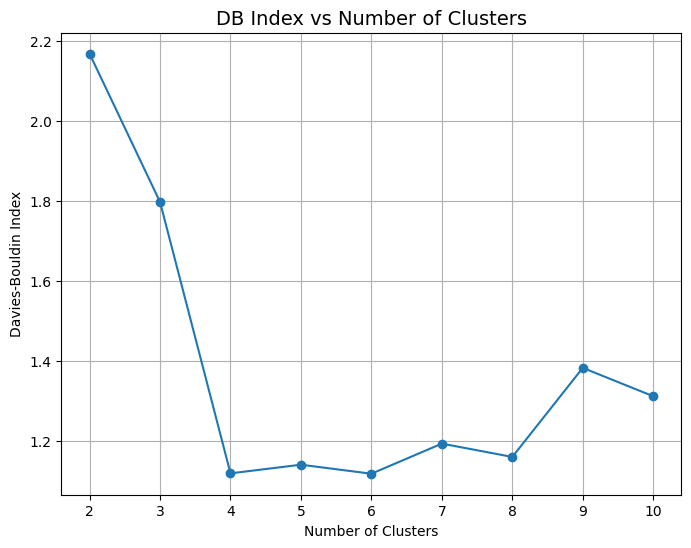

Optimal number of clusters: 6


In [14]:
cluster_range = range(2, 11)
db_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)

    db_index = davies_bouldin_score(scaled_data, kmeans.labels_)
    db_scores.append(db_index)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, db_scores, marker='o')
plt.title('DB Index vs Number of Clusters', fontsize=14)
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)
plt.show()

optimal_k = cluster_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")


In [15]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

print(kmeans.cluster_centers_)
print(customer_data[['CustomerID', 'Cluster']].head())


[[-0.05418816  1.87689298 -0.57928445 -0.54831888 -0.6491753   1.04593489
   1.12863168  0.20522379]
 [ 0.21591808 -0.53279543 -0.57928445 -0.54831888  1.54041597  0.13704397
   0.05810662  0.05514233]
 [ 0.31686206 -0.53279543  1.72626765 -0.54831888 -0.6491753  -0.79282386
  -0.5181648  -0.72625884]
 [ 0.00549204  1.87689298 -0.57928445 -0.54831888 -0.6491753  -0.73435209
  -0.83583086  0.01713615]
 [-0.3254492  -0.53279543 -0.57928445  1.82375628 -0.6491753  -0.08541999
   0.12733536 -0.20065702]
 [-0.2387472  -0.53279543  1.72626765 -0.54831888 -0.6491753   0.76157806
   0.26612891  0.93244547]]
  CustomerID  Cluster
0      C0001        1
1      C0002        3
2      C0003        1
3      C0004        1
4      C0005        3


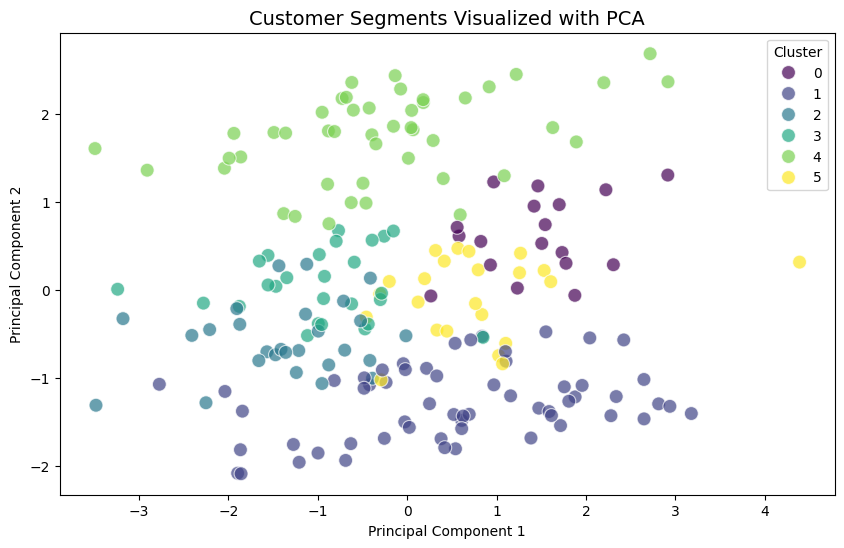

In [16]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=customer_data['Cluster'], palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segments Visualized with PCA', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()


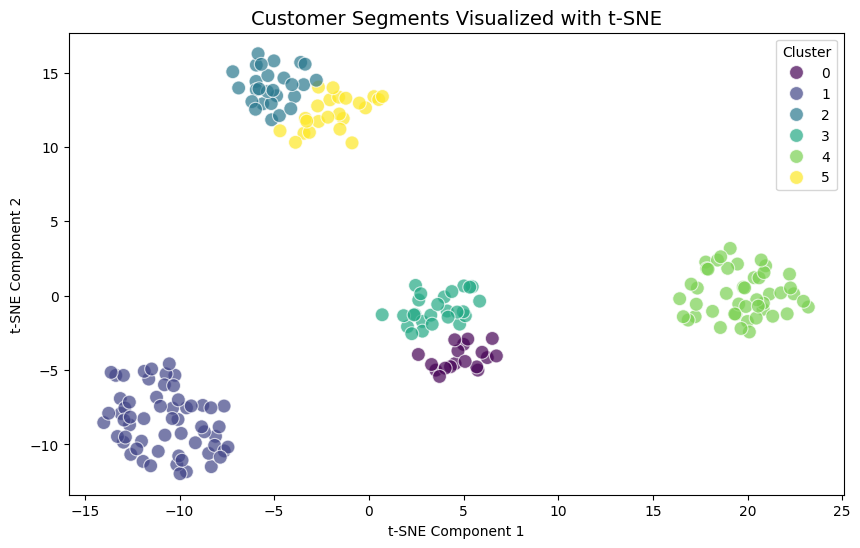

In [17]:
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=customer_data['Cluster'], palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segments Visualized with t-SNE', fontsize=14)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()


In [18]:
cluster_summary = customer_data.groupby('Cluster')['CustomerID'].count().reset_index()
cluster_summary.columns = ['Cluster', 'CustomerCount']
print(cluster_summary)

customer_data[['CustomerID', 'Cluster']].to_csv('Customer_Segmentation.csv', index=False)


   Cluster  CustomerCount
0        0             18
1        1             59
2        2             27
3        3             26
4        4             46
5        5             23
